# Nested sampling

In the [MCMC tutorial](./mcmc.html), Bayes theorem was shown, 

$$ p = \frac{P L}{Z}, $$

where where, $p$ is the posterior probability, $P$ is the prior probability, $L$ is the likelihood, and $Z$ is the evidence. 
Normally, in the evaluation of the posterior probability, the evidence is removed as a constant of proportionality. 
This is due to the fact that it is a single value for a given model and dataset pair. 

However, sometimes it is desirable to find the evidence for a model to a given dataset.
In particular, when we want to compare the evidence for a series of models, to determine which best describes the dataset.
In order to achieve this, `uravu` is able to perform [nested sampling](https://doi.org/10.1063/1.1835238) to estimate the Bayesian evidence for a model given a particular dataset. 

This tutorial will show how this is achieved, and show the utility of Bayesian model selection. 

However, as always we must first create some *synthetic* data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from uravu.distribution import Distribution
from uravu.relationship import Relationship
from uravu import plotting, utils

In [2]:
np.random.seed(2)

This synthetic data is log-normally distributed in the ordinate. 
Below, we use a `scipy.stats.rv_continuous` object to define our ordinate data. 

In [6]:
x = np.linspace(10, 50, 20)
y = .3 * x ** 2 - 1.4 * x + .2
Y = []
for i in y:
    Y.append(lognorm(s=2, loc=i, scale=1))

From looking at the code used to synthesize this data, it is clear that the functional form of the model is a second order polynomial. 
However, if this was data collected from some measurement and the physical theory suggests it should be analysed with a polynormial of unknown degree then Bayesian model selection would be the ideal tool to find the best model. 

Let's quickly write a few models to perform the `n` degree polynomial analysis with. 

In [7]:
def one_degree(x, a, b):
    return b * x + a

def two_degree(x, a, b, c):
    return c * x ** 2 + b * x + a

def three_degree(x, a, b, c, d):
    return d * x ** 3 + c * x ** 2 + b * x + a

def four_degree(x, a, b, c, d, e):
    return e * x ** 4 + d * x ** 3 + c * x ** 2 + b * x + a

With these functions defined, we can now build the `Relationship` objects for each of the functions. Using the `'diff_evo'` string to perform the global optimisation by [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution). 

In [8]:
one_modeller = Relationship(one_degree, x, Y, 
                            bounds=((-300, 0), (-2, 20)))
one_modeller.max_likelihood('diff_evo')

In [9]:
two_modeller = Relationship(two_degree, x, Y, 
                            bounds=((-2, 2), (-2, 2), (-1, 1)))
two_modeller.max_likelihood('diff_evo')

In [10]:
three_modeller = Relationship(three_degree, x, Y, 
                              bounds=((-2, 2), (-2, 2), (-1, 1), (-0.2, 0.2)))
three_modeller.max_likelihood('diff_evo')

In [11]:
four_modeller = Relationship(four_degree, x, Y, 
                             bounds=((-2, 2), (-2, 2), (-1, 1), (-0.2, 0.2), (-0.02, 0.02)))
four_modeller.max_likelihood('diff_evo')

Having built these, lets see what the maximum likelihood variables are for each. 

In [12]:
print(one_modeller.variable_modes)

[-233.02181382   16.91419436]


In [13]:
print(two_modeller.variable_modes)

[ 0.50360562 -1.22086729  0.29722928]


In [14]:
print(three_modeller.variable_modes)

[-3.41783502e-01 -1.19673254e+00  2.97185414e-01 -8.76900188e-07]


In [15]:
print(four_modeller.variable_modes)

[ 1.20603075e+00  4.35409450e-01  1.48054997e-01  4.14102794e-03
 -3.65616682e-05]


It is possible to quickly visualise the relationship with the `plotting` function, which shows the log-normal distribution of the ordinate data. 

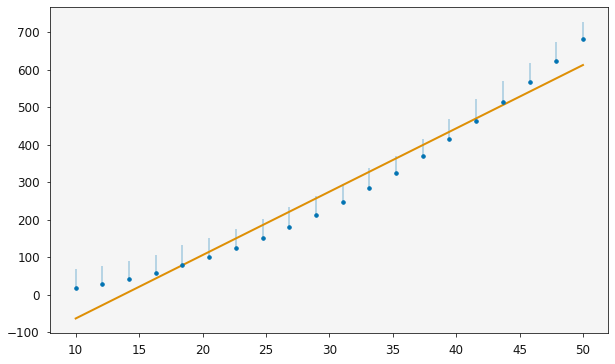

In [16]:
plotting.plot_relationship(one_modeller)
plt.show()

Above, in the `variable_modes`, we can see that the highest order terms are quite small for the larger degree of polynomial. 
Let's see what effect this has on the evidence. 

Note that `uravu` and `dynesty` calculates the natural log of the evidence, $\ln{Z}$ and while this tutorial show how [nested sampling](http://doi.org/10.1063/1.1835238) may be used, `uravu` and `dynesty` also enable the use of [dynamic nested sampling](https://doi.org/10.1007/s11222-018-9844-0) (by setting the keyword argument `dynamic` to `True`).

In [17]:
one_modeller.nested_sampling()

3281it [00:20, 158.05it/s, +500 | bound: 5 | nc: 1 | ncall: 20604 | eff(%): 18.351 | loglstar:   -inf < -110.062 <    inf | logz: -115.772 +/-  0.137 | dlogz:  0.001 >  0.509]


In [18]:
two_modeller.nested_sampling()

3495it [00:25, 138.14it/s, +500 | bound: 6 | nc: 1 | ncall: 21404 | eff(%): 18.665 | loglstar:   -inf < -82.411 <    inf | logz: -88.545 +/-  0.142 | dlogz:  0.001 >  0.509]


In [19]:
three_modeller.nested_sampling()

5843it [00:37, 154.48it/s, +500 | bound: 15 | nc: 1 | ncall: 28341 | eff(%): 22.381 | loglstar:   -inf < -84.331 <    inf | logz: -95.193 +/-  0.200 | dlogz:  0.001 >  0.509]   


In [20]:
four_modeller.nested_sampling()

8725it [01:01, 140.73it/s, +500 | bound: 29 | nc: 1 | ncall: 39087 | eff(%): 23.601 | loglstar:   -inf < -83.449 <    inf | logz: -100.113 +/-  0.254 | dlogz:  0.001 >  0.509]   


Having estimated $\ln{Z}$ for each `Relationship`, lets plot them as a function of the number of variables in the model.

In [21]:
variables = [len(one_modeller.variables), len(two_modeller.variables),
             len(three_modeller.variables), len(four_modeller.variables)]
ln_evidence = [one_modeller.ln_evidence.n, two_modeller.ln_evidence.n,
               three_modeller.ln_evidence.n, four_modeller.ln_evidence.n]
ln_evidence_err = [one_modeller.ln_evidence.s, two_modeller.ln_evidence.s,
                   three_modeller.ln_evidence.s, four_modeller.ln_evidence.s]

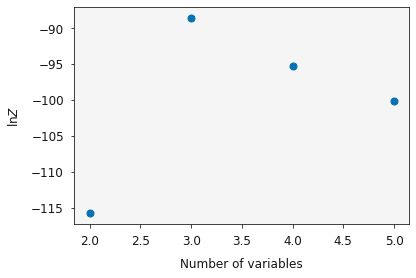

In [22]:
plt.errorbar(variables, ln_evidence, ln_evidence_err, marker='o', ls='')
plt.xlabel('Number of variables')
plt.ylabel(r'$\ln{Z}$')
plt.show()

We can see that the evidence reaches a maxiumum at 3 variables (the `two_degree` model), this indicates that this is the most probable model for analysis of this dataset. 

Finally, we can use some built in functionality of `uravu` to compare different evidence values, in a value known as the [Bayes factor](https://doi.org/10.2307/2291091). 
Let's compare the `one_degree` and `two_degree` models.

In [23]:
print(utils.bayes_factor(two_modeller.ln_evidence, one_modeller.ln_evidence))

54.5+/-0.4


The Bayes factor between the two and one degree models, $2\ln{B_{21}}$, has a value of $\sim81$. 
The Table in [Kass and Raftery](https://doi.org/10.2307/2291091) suggests that this shows "Strong" evidence for the model with more variables (the `two_degree` model). 

This means that it is sensible to go ahead and use the `two_degree` model in the further analysis of our data.
Below the plot of the second order polynomial is shown over the data. 

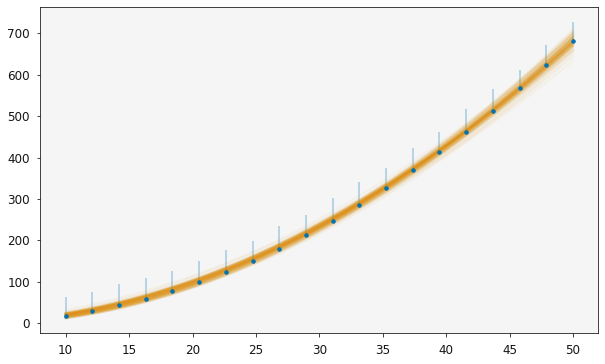

In [24]:
plotting.plot_relationship(two_modeller)
plt.show()